### Data Augmentation using torch.vision

**Date:** 13/11/2021  
**Author:** Murad Popattia

In [1]:
# import libraries
import torch
import torch.nn as nn # all the layers
import torch.optim as optim # all the optimization algos
import torch.nn.functional as F # all the activation functions
from torch.utils.data import DataLoader, Dataset # helps to create mini-batches etc.
import torchvision # for importing models
import torchvision.transforms as transforms # for transformations on the dataset
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import spacy
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

Reutilizing the cats and dogs dataset made

In [9]:
# define the transformations
my_transforms = transforms.Compose([
    transforms.ToPILImage(), # all the transforms work on this
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomHorizontalFlip(p=0.5), # we define a probability for the flip as well
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0])
])

"""
Normalize helps in training, but for this case it is not doing anything as subtract zero and divide by 1.
We would find those values first across all channels and then mention them here, to help in training
"""

'\nNormalize helps in training, but for this case it is not doing anything as subtract zero and divide by 1.\nWe would find those values first across all channels and then mention them here, to help in training\n'

We can visualize the augmentations as well

In [6]:
# read in the two images
img_1 = cv2.imread("../datasets/augmentation_dataset_cats/cat.1.jpg")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

img_2 = cv2.imread("../datasets/augmentation_dataset_cats/cat.2.jpg")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

In [7]:
img_path = "../datasets/augmentation_dataset_cats/"

imgs = []

img_count = 3
for img in [img_1, img_2]:
    for _ in range(10):
        temp = my_transforms(img)
        utils.save_image(temp, f"{img_path}cat.{img_count}.png")
        imgs.append(temp)
        
        img_count += 1

In [5]:
len(imgs)

10

### Visualizing the augmentations

torch.Size([3, 906, 1132])


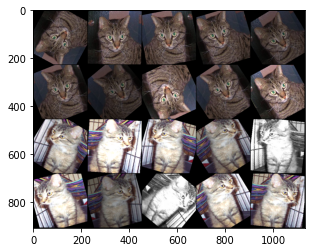

In [8]:
# helper function of displaying the dataset
def show(img):
    npimg = img.numpy() # convert the tensor to numpy

    # convert to h*w*c from c*h*w
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    
x_grid = utils.make_grid(imgs, nrow = 5) # nrow means the no. of images per column
print(x_grid.shape)
show(x_grid)